In [64]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255.,
                                                         validation_split=.2,
                                                         horizontal_flip=True,
                                                         rotation_range=20)

In [3]:
example = datagen.flow_from_directory('./lfw-funneled/', class_mode='input').__next__()

Found 13233 images belonging to 1 classes.


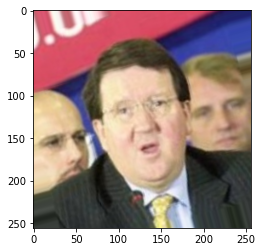

In [27]:
plt.imshow(example[0][1])

In [2]:
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Flatten, Dense, LeakyReLU

LATENT_DIM = 512

def build_encoder(input_dim, output_dim, conv_layers, activation=LeakyReLU):
    encoder_input = Input(shape=input_dim, name='encoder_input')
    x = encoder_input
    
    for c, l in enumerate(conv_layers):
        x = Conv2D(l['filters'], l['k_size'], strides = l['strides'], 
                   padding='same', name='encoder_conv' + str(c))(x)
        x = activation(name='activation' + str(c))(x)
    
    shape_before_flattening = tf.keras.backend.int_shape(x)[1:] # skipping over batch dimension
    
    x = Flatten()(x)
    encoder_output = Dense(output_dim, name='encoder_output')(x)
    model = tf.keras.models.Model(encoder_input, encoder_output, name='encoder')
    
    return encoder_input, encoder_output, shape_before_flattening, model

def build_decoder(input_dim, shape_before_flattening, conv_layers, activation=LeakyReLU):
    decoder_input = Input(shape=(input_dim,), name='decoder_input')
    
    x = decoder_input
    
    x = Dense(np.prod(shape_before_flattening))(decoder_input)
    x = tf.keras.layers.Reshape(shape_before_flattening)(x)
    for c, l in enumerate(conv_layers):
        x = Conv2DTranspose(l['filters'], l['k_size'], l['strides'],
                           padding='same', name='decoder_conv_t' + str(c))(x)
        if c < len(conv_layers)-1:
            x = activation()(x)
        else:
            x = tf.keras.layers.Activation('sigmoid')(x)
    decoder_output = x
    
    return decoder_input, decoder_output, tf.keras.models.Model(decoder_input, decoder_output)

In [3]:
conv_layers = [{'filters': 32, 'k_size': 3, 'strides': 2},
              {'filters': 32, 'k_size': 3, 'strides': 2},
              {'filters': 64, 'k_size': 3, 'strides': 2},
              {'filters': 64, 'k_size': 3, 'strides': 2},
              {'filters': 64, 'k_size': 3, 'strides': 2}]

encoder_input, encoder_output, shape_before_flattening, encoder = build_encoder((256,256,3), LATENT_DIM, conv_layers)

deconv_layers = [{'filters': 64, 'k_size': 3, 'strides': 2},
                {'filters': 64, 'k_size': 3, 'strides': 2},
                {'filters': 64, 'k_size': 3, 'strides': 2},
                {'filters': 32, 'k_size': 3, 'strides': 2},
                {'filters': 3, 'k_size': 3, 'strides': 2}] # last one must have 3 filters to emulate the r,g,b channels

decoder_input, decoder_output, decoder = build_decoder(LATENT_DIM, shape_before_flattening, deconv_layers)

In [4]:
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 256, 256, 3)]     0         
_________________________________________________________________
encoder_conv0 (Conv2D)       (None, 128, 128, 32)      896       
_________________________________________________________________
activation0 (LeakyReLU)      (None, 128, 128, 32)      0         
_________________________________________________________________
encoder_conv1 (Conv2D)       (None, 64, 64, 32)        9248      
_________________________________________________________________
activation1 (LeakyReLU)      (None, 64, 64, 32)        0         
_________________________________________________________________
encoder_conv2 (Conv2D)       (None, 32, 32, 64)        18496     
_________________________________________________________________
activation2 (LeakyReLU)      (None, 32, 32, 64)        0   

In [5]:
decoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 512)]             0         
_________________________________________________________________
dense (Dense)                (None, 4096)              2101248   
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 64)          0         
_________________________________________________________________
decoder_conv_t0 (Conv2DTrans (None, 16, 16, 64)        36928     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16, 16, 64)        0         
_________________________________________________________________
decoder_conv_t1 (Conv2DTrans (None, 32, 32, 64)        36928     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 64)        0     

In [6]:
simple_ae_input = encoder_input
simple_ae_output = decoder(encoder_output)

ae = tf.keras.models.Model(inputs=simple_ae_input, outputs=simple_ae_output, name='AE')
ae.compile(optimizer='adam', loss='mse')
ae.summary()

Model: "AE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 256, 256, 3)]     0         
_________________________________________________________________
encoder_conv0 (Conv2D)       (None, 128, 128, 32)      896       
_________________________________________________________________
activation0 (LeakyReLU)      (None, 128, 128, 32)      0         
_________________________________________________________________
encoder_conv1 (Conv2D)       (None, 64, 64, 32)        9248      
_________________________________________________________________
activation1 (LeakyReLU)      (None, 64, 64, 32)        0         
_________________________________________________________________
encoder_conv2 (Conv2D)       (None, 32, 32, 64)        18496     
_________________________________________________________________
activation2 (LeakyReLU)      (None, 32, 32, 64)        0        

In [12]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss')
checkpoint = tf.keras.callbacks.ModelCheckpoint('best_7-25.h5', monitor='val_loss', verbose=1, save_best_only=True)

In [14]:
train_generator = datagen.flow_from_directory('./lfw-funneled/lfw_funneled', shuffle=True, seed=1337, subset='training', class_mode='input')
test_generator = datagen.flow_from_directory('./lfw-funneled/lfw_funneled', shuffle=True, seed=1337, subset='validation', class_mode='input')

Found 12161 images belonging to 5749 classes.
Found 1072 images belonging to 5749 classes.


((256, 256, 3), (256, 256, 3))

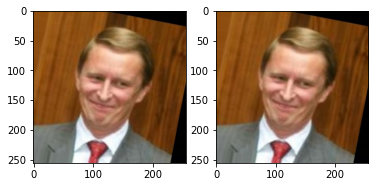

In [15]:
val = test_generator.__next__()
plt.subplot(121)
plt.imshow(val[0][0])
plt.subplot(122)
plt.imshow(val[1][0])
(val[0][0].shape, val[1][0].shape)

In [364]:
tf.config.list_physical_devices('GPU')

[]

In [365]:
ae.fit(train_generator, batch_size=128,
      validation_data=test_generator, initial_epoch=0,
      epochs=30, callbacks=[early_stop, checkpoint])

Epoch 1/30
381/381 [==============================] - ETA: 0s - loss: 0.0307
Epoch 00001: val_loss improved from inf to 0.01545, saving model to best_7-25.h5
381/381 [==============================] - 585s 2s/step - loss: 0.0307 - val_loss: 0.0155
Epoch 2/30
381/381 [==============================] - ETA: 0s - loss: 0.0131
Epoch 00002: val_loss improved from 0.01545 to 0.01066, saving model to best_7-25.h5
381/381 [==============================] - 819s 2s/step - loss: 0.0131 - val_loss: 0.0107
Epoch 3/30
381/381 [==============================] - ETA: 0s - loss: 0.0101
Epoch 00003: val_loss improved from 0.01066 to 0.00913, saving model to best_7-25.h5
381/381 [==============================] - 613s 2s/step - loss: 0.0101 - val_loss: 0.0091
Epoch 4/30
381/381 [==============================] - ETA: 0s - loss: 0.0091
Epoch 00004: val_loss improved from 0.00913 to 0.00839, saving model to best_7-25.h5
381/381 [==============================] - 734s 2s/step - loss: 0.0091 - val_loss: 0.0

In [18]:
ae.weights = tf.keras.models.load_model(ae, 'best_7-25.h5').weights

ValueError: dictionary update sequence element #0 has length 1; 2 is required

(256, 256, 3)

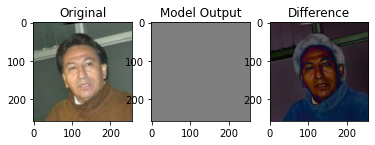

In [16]:
img = np.array(val[0][14])
img_reshaped = img.reshape((1,256,256,3))
prediction = ae.predict(img_reshaped)
plt.subplot(131)
plt.title('Original')
plt.imshow(img)
plt.subplot(132)
plt.title('Model Output')
plt.imshow(prediction[0])
plt.subplot(133)
plt.title('Difference')
plt.imshow(np.abs(img-prediction[0]))
img.shape

In [7]:
encoder = tf.keras.models.Model(inputs=input_layer, outputs=ae.get_layer(name='latent').output)
encoder.summary()

NameError: name 'input_layer' is not defined

In [10]:
coding_vector = encoder.predict(img_reshaped)
coding_vector

NameError: name 'img_reshaped' is not defined

(256, 256, 3)

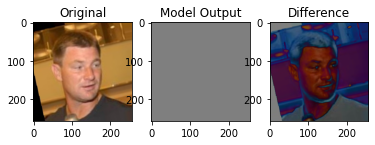

In [21]:
img2 = np.array(val[0][8])
img_reshaped2 = img2.reshape((1,256,256,3))
prediction = ae.predict(img_reshaped2)
plt.subplot(131)
plt.title('Original')
plt.imshow(img2)
plt.subplot(132)
plt.title('Model Output')
plt.imshow(prediction[0])
plt.subplot(133)
plt.title('Difference')
plt.imshow(np.abs(img2-prediction[0]))
img2.shape

In [288]:
coding_vector2 = encoder.predict(img_reshaped2)
coding_vector2

array([[0.4761842 , 0.43570516, 0.43416527, 0.17875507, 0.5114434 ,
        0.2239067 , 0.34228534, 0.42326075, 0.16865933, 0.03983992,
        0.2833717 , 0.3215335 , 0.3429168 , 0.3093089 , 0.01951453,
        0.593413  , 0.12488768, 0.43774286, 0.26320583, 0.5702418 ,
        0.7643193 , 0.7211385 , 0.41211596, 0.7270837 , 0.31586114,
        0.11485699, 0.14572427, 0.33882618, 0.39792645, 0.8085699 ,
        0.3926203 , 0.6735614 , 0.48920298, 0.7034707 , 0.23835853,
        0.7066568 , 0.29839528, 0.69967127, 0.46813345, 0.0056183 ,
        0.37399867, 0.28837755, 0.47060832, 0.01839751, 0.00476706,
        0.42892247, 0.4512389 , 0.75360966, 0.5344202 , 0.3882942 ,
        0.6999769 , 0.44554985, 0.13809758, 0.5702612 , 0.64790154,
        0.5814303 , 0.46257365, 0.18724525, 0.22100204, 0.16659087,
        0.10172915, 0.4458779 , 0.08630133, 0.23993582, 0.2528298 ,
        0.39033172, 0.40095085, 0.4016239 , 0.3549075 , 0.5527107 ,
        0.24859911, 0.5743207 , 0.58058137, 0.75

In [290]:
np.mean(coding_vector - coding_vector2)

-0.047534354

In [11]:
tf.compat.v1.disable_eager_execution()

In [7]:
import tensorflow.keras.backend as K
from tensorflow.keras.layers import BatchNormalization, Dropout

def build_variational_encoder(input_dim, output_dim, conv_layers, activation=LeakyReLU,
                              use_batch_norm=False, use_dropout=False):
    global K
    K.clear_session()
    
    encoder_input = Input(shape=input_dim, name='encoder_input')
    x = encoder_input
    print(len(conv_layers))
    for c, l in enumerate(conv_layers):
        x = Conv2D(l['filters'], l['k_size'], strides=l['strides'], padding='same', name='encoder_conv' + str(c))(x)
        
        if use_batch_norm:
            x = BatchNormalization()(x)
        x = activation()(x)
        
        if use_dropout:
            x = Dropout(.25)(x)
        
    shape_before_flattening = K.int_shape(x)[1:]
    x = Flatten()(x)

    mean_mu = Dense(output_dim, name='mu')(x)
    log_var = Dense(output_dim, name='log_var')(x)

    def sampling(args):
        mean_mu, log_var = args
        epsilon = K.random_normal(shape=K.shape(mean_mu), mean=0., stddev=1.)
        return mean_mu + K.exp(log_var/2)*epsilon

    encoder_output = tf.keras.layers.Lambda(sampling, name='encoder_output')([mean_mu, log_var])
    model = tf.keras.models.Model(encoder_input, encoder_output, name='VAE_encoder')
    return encoder_input, encoder_output, mean_mu, log_var, shape_before_flattening, model

In [8]:
conv_layers = [{'filters': 32, 'k_size': 3, 'strides': 2},
              {'filters': 32, 'k_size': 3, 'strides': 2},
              {'filters': 64, 'k_size': 3, 'strides': 2},
              {'filters': 64, 'k_size': 3, 'strides': 2},
              {'filters': 64, 'k_size': 3, 'strides': 2}]

encoder_input, encoder_output, mu, log_var, shape_before_flattening, encoder = build_variational_encoder((256,256,3), LATENT_DIM, conv_layers)

deconv_layers = [{'filters': 64, 'k_size': 3, 'strides': 2},
                {'filters': 64, 'k_size': 3, 'strides': 2},
                {'filters': 64, 'k_size': 3, 'strides': 2},
                {'filters': 32, 'k_size': 3, 'strides': 2},
                {'filters': 3, 'k_size': 3, 'strides': 2}] # last one must have 3 filters to emulate the r,g,b channels

decoder_input, decoder_output, decoder = build_decoder(LATENT_DIM, shape_before_flattening, deconv_layers)

5


In [9]:
decoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 512)]             0         
_________________________________________________________________
dense (Dense)                (None, 4096)              2101248   
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 64)          0         
_________________________________________________________________
decoder_conv_t0 (Conv2DTrans (None, 16, 16, 64)        36928     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
decoder_conv_t1 (Conv2DTrans (None, 32, 32, 64)        36928     
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 32, 32, 64)        0     

In [10]:
vae_input = encoder_input

vae_output = decoder(encoder_output)

vae = tf.keras.models.Model(vae_input, vae_output, name='VAE')

In [11]:
LOSS_FACTOR = 10000

def kl_loss(y_true, y_pred):
    return -0.5 * K.sum(1 + log_var - K.square(mu) - K.exp(log_var), axis = 1)

def total_loss(y_true, y_pred):
    kl = tf.keras.losses.KLDivergence()
    return LOSS_FACTOR*tf.keras.losses.mse(y_true, y_pred) + kl(y_true, y_pred)


vae.compile(optimizer='adam', loss=total_loss, metrics=['mse', kl_loss])

In [423]:
early_stop_vae = tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss')
checkpoint_vae = tf.keras.callbacks.ModelCheckpoint('./best_vae_7-25.h5', save_best_only=True)

In [424]:
vae.fit(train_generator, epochs=30,
       validation_data=test_generator, callbacks=[early_stop_vae, checkpoint_vae])

Epoch 1/30
381/381 [==============================] - 601s 2s/step - loss: 25679.6984 - mse: 0.0313 - kl_loss: 1602.0269 - val_loss: 18217.0724 - val_mse: 0.0148 - val_kl_loss: 2019.2612
Epoch 2/30
381/381 [==============================] - 757s 2s/step - loss: 16841.9847 - mse: 0.0127 - kl_loss: 2336.7380 - val_loss: 15141.0585 - val_mse: 0.0103 - val_kl_loss: 2578.1040
Epoch 3/30
381/381 [==============================] - 806s 2s/step - loss: 14710.9711 - mse: 0.0097 - kl_loss: 2661.2288 - val_loss: 13947.4914 - val_mse: 0.0087 - val_kl_loss: 2682.5164
Epoch 4/30
381/381 [==============================] - 611s 2s/step - loss: 13852.5141 - mse: 0.0086 - kl_loss: 2741.8115 - val_loss: 13052.1431 - val_mse: 0.0077 - val_kl_loss: 2776.3940
Epoch 5/30
381/381 [==============================] - 615s 2s/step - loss: 13103.9144 - mse: 0.0077 - kl_loss: 2828.2397 - val_loss: 12602.1111 - val_mse: 0.0072 - val_kl_loss: 2839.7080
Epoch 6/30
381/381 [==============================] - 619s 2s/ste

In [12]:
vae.load_weights('./vae_weights.h5')

In [13]:
encoder = tf.keras.models.Model(inputs=vae.input, outputs=vae.get_layer(name='encoder_output').output)

(720, 1080, 3)

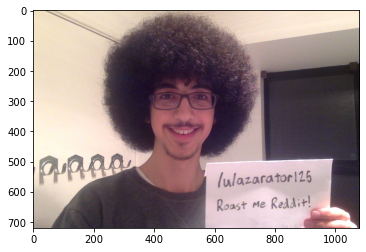

In [17]:
import cv2
img = cv2.imread('./faces/4xob21.png')
plt.imshow(to_rgb(img))
img.shape

In [15]:
haar_cascade_face = cv2.CascadeClassifier('data/haarcascade_frontalface_default.xml')

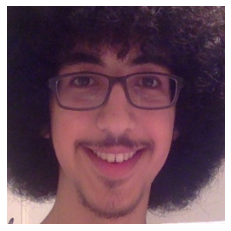

In [16]:
def detect_faces(img, extension=(0,0), resize=(256,256), draw_rects=True):
    img_gray = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2GRAY) # cvt to grayscale for faster results
    
    if type(extension)==float or type(extension)==int:
        extension = (extension, extension)
    if extension[0]<1 or extension[1]<1:
        extension = (int(extension[0]*len(img[0])), int(extension[1]*len(img))) # if <1, treat as a perecentage
    
    faces_rects = haar_cascade_face.detectMultiScale(img_gray, scaleFactor = 1.2, minNeighbors = 5)
    if len(faces_rects) == 0:
        return None, None
    if draw_rects: # should we draw the rectangles onto the original image?
        for (x,y,w,h) in faces_rects:
            left_x = int(max(x-extension[0]/2,0))
            right_x = int(min(x+(extension[0]/2)+w,len(img[0])))
            top_y = int(max(y-extension[1]/2,0))
            bottom_y = int(min(y+(extension[1]/2)+h, len(img)))
            cv2.rectangle(img_gray, (left_x,bottom_y), (right_x,top_y), (0, 255, 0), 10)
    face_imgs = []
    for (x,y,w,h) in faces_rects:
        left_x = int(max(x-extension[0]/2,0))
        right_x = int(min(x+(extension[0]/2)+w,len(img[0])))
        bottom_y = int(max(y-extension[1]/2,0))
        top_y = int(min(y+(extension[1]/2)+h, len(img)))
        img_slice = img[bottom_y:top_y, left_x:right_x]
        face_imgs.append(to_rgb(cv2.resize(img_slice,resize)))
    return face_imgs, img_gray

def to_rgb(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def display_faces(imgs):
    if imgs is not None:
        for c,face in enumerate(imgs):
            plt.subplot(1,len(imgs),c+1)
            plt.axis('off')
            plt.imshow(face)
    else:
        print('Face not found!')
        
face_imgs, im_gray = detect_faces(img, extension=.1, draw_rects=True)  
display_faces(face_imgs)

In [19]:
img = to_rgb(face_imgs[0])

In [25]:
def encode_vals(img):
    img = img / 255.
    img = img.reshape((1, 256, 256, 3))
    return encoder.predict(img)[0]

def autoencoder_predict(img):
    img = img / 255.
    img = img.reshape((1, 256, 256, 3))
    return vae.predict(img)[0]

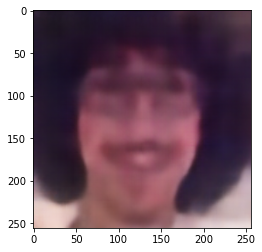

In [22]:
plt.imshow(autoencoder_predict(to_rgb(img)))

In [23]:
encode_vals(img)

array([-4.89424169e-01, -1.84125841e+00,  3.90918851e-01,  1.52674377e+00,
        6.82466865e-01,  1.83206141e+00, -1.41153634e+00, -1.44199145e+00,
       -1.51797926e+00,  1.52146351e+00,  7.81816542e-01, -1.75438356e+00,
        2.27900672e+00, -2.00731039e+00,  7.16039538e-01,  6.89066887e-01,
        2.05344987e+00, -3.68547998e-02, -3.21735859e+00,  2.64974618e+00,
       -4.62819993e-01,  1.02278101e+00, -2.08749843e+00, -2.81029320e+00,
        4.08883142e+00,  2.96033931e+00, -1.50400901e+00,  1.79945493e+00,
       -6.57101095e-01,  5.14242053e-01, -1.37037349e+00,  9.14283216e-01,
       -2.11187318e-01,  1.00377297e+00, -1.58884048e+00,  2.46615216e-01,
        5.95862210e-01, -1.55224836e+00,  2.98330963e-01,  1.61393750e+00,
       -2.76008034e+00,  2.93760872e+00,  2.67184734e+00, -1.51151526e+00,
       -1.21961504e-01,  7.89978728e-02, -5.74581504e-01, -1.80368280e+00,
       -6.76441550e-01, -1.02451324e+00, -4.47365940e-02, -8.23910892e-01,
        8.71194363e-01, -

In [18]:
# encode reddit imgs
import glob
import csv
from tqdm.notebook import tqdm

In [19]:
vae.summary()

Model: "VAE"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encoder_conv0 (Conv2D)          (None, 128, 128, 32) 896         encoder_input[0][0]              
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 128, 128, 32) 0           encoder_conv0[0][0]              
__________________________________________________________________________________________________
encoder_conv1 (Conv2D)          (None, 64, 64, 32)   9248        leaky_re_lu[0][0]                
________________________________________________________________________________________________

In [906]:
with open('reddit_embeddings.csv', 'w') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(['ID'] + [c for c in range(512)])
    for filename in tqdm(glob.glob('./faces/*.png')):
        try:
            img = to_rgb(cv2.resize(cv2.imread(filename), (256,256)))
        except:
            continue
        face_imgs, im_gray = detect_faces(img, extension=.1, draw_rects=False)
        if face_imgs is not None:
            encodings = encode_vals(to_rgb(face_imgs[0]))
            id_tag = filename[filename.index('\\')+1:-4]
            writer.writerow([id_tag] + [enc for enc in encodings])

'7j2og3'

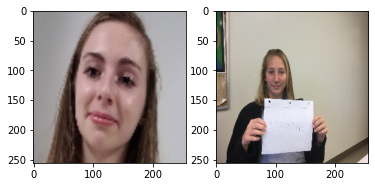

In [26]:
#testing just one image through the pipeline
img = to_rgb(cv2.resize(cv2.imread('./test_photos/jill.jpg'),(256,256)))
face_imgs, im_gray = detect_faces(img, extension=.1, draw_rects=False)
if face_imgs is not None:
    plt.subplot(121)
    plt.imshow(to_rgb(face_imgs[0]))
    encodings = encode_vals(to_rgb(face_imgs[0]))
closest = find_closest_encoding(encodings)
plt.subplot(122)
plt.imshow(to_rgb(cv2.resize(cv2.imread('./faces/{}.png'.format(closest)),(256,256))))
closest

In [27]:
import pandas as pd

df = pd.read_csv('reddit_embeddings.csv', index_col='ID')
df.head()

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
ID,,,,,,,,,,,,,,,,,,,,,
3by2xz,-5.156562,-0.048527,2.032717,-3.258749,2.579635,-0.362336,-1.969622,0.484039,2.179114,0.021124,...,-0.421783,0.712104,2.051864,-0.576414,-0.834513,-1.904513,-0.738025,-0.383928,-1.757450,-1.587688
3c3ifn,-1.742397,-0.462067,-0.465146,0.988589,-1.109966,-0.789569,-1.439940,0.493868,2.017582,2.248815,...,0.588440,-1.216538,-0.279593,-0.242102,-2.148478,1.065180,-0.966900,-0.099112,-2.343195,0.387135
3c7ewj,-1.609658,0.560024,1.248769,-1.566604,2.012107,-0.913335,-3.130009,1.184138,2.958905,0.242812,...,-0.779338,0.003237,2.450308,-0.119816,-2.319169,-0.273096,-2.247153,-0.268586,-1.542782,0.988287
3c7rnc,-0.894452,-4.419951,-0.910546,-4.062506,3.213312,-3.026805,-2.345867,-1.926320,1.050578,0.044829,...,-1.883672,-1.978476,2.345271,3.474415,1.945866,-0.374042,-0.011051,0.656641,-2.994651,3.255277
3caw80,-4.238278,-1.599475,0.096288,-2.995051,6.392457,0.740162,0.726725,2.191219,1.389834,0.193539,...,-0.680928,0.172464,1.885360,-2.189818,1.888408,-0.359822,2.076488,-1.006885,0.405289,1.279431


In [22]:
len(df)

1557

In [28]:
def find_closest_encoding(enc, skip=[]):
    closest_dist = compute_dist(df.iloc[0], enc)
    closest_id = df.iloc[0].name
    for index, row in df.iterrows():
        if index in skip:
            continue
        dist = compute_dist(row, enc)
        if dist < closest_dist:
            closest_dist = dist
            closest_id = row.name
    return closest_id

def compute_dist(enc1, enc2):
    enc1 = np.array(enc1)
    enc2 = np.array(enc2)
    return np.mean(np.abs(enc1-enc2), axis=None)

In [29]:
# test, should return 3by2xz
find_closest_encoding(df.iloc[0])

'3by2xz'

In [15]:
import csv
import collections

In [33]:
import os
from PIL import Image

for filename in os.listdir('./faces'):
    if filename.endswith('.jpeg'):
        print(filename)

In [36]:
roasts = collections.defaultdict(list)

with open('reddit_roasts.csv', 'r', encoding='utf-8') as f:
    reader = csv.reader(f, delimiter=',')
    reader.__next__()
    for row in reader:
        if row==[]:
            continue
        _id = row[0]
        posts_roasts = [roast.replace('\\CoMmA!',',') for roast in row[1:]]
        print(_id, posts_roasts)
        
        roasts['info'].append({'ID': _id, 'Roasts': posts_roasts, 'Filename': './drive/MyDrive/faces/{}.png'.format(_id)})
        #roasts += "{'ID': {}, 'Roasts': {}}".format(_id, posts_roasts) +  ','
#roasts = roasts[:-1] + '}'

av1hiv ['A future cat litter spokeswoman ', "You are literally what comes to my mind when I think of a Karen (A em,entitled mother) Visit r/entitledparents if you don't understand(just scroll down a little and you should see Karen in a title.\n(It's a reference is basically what I'm trying to say.)", 'Getting injected with narcan on three separate occasions does not make you an EMT student.']
av1nso ['Trumps hair grew a wart', 'The only good thing I see in this picture is the raptors sweater. Everything else is an L.']
av1nua ['Those hangovers, sorry, ‘sick days’ are going hit you like a brick when you’re 30. ', '[Anime villain looking ass](https://i.ytimg.com/vi/ESl-is81bLQ/maxresdefault.jpg)', 'You look like Jenna Marbles dog', 'You look like the sister of Casper the Friendly Ghost.', 'Just say unemployed, nobody can possible think any less of you anyways.']
av2orn ['You look like you’ve seen a Venn diagram for the first time.']
av3wo7 ['You\'re wearing a choker that doesn\'t fit, a 

In [38]:
import json

with open('reddit_roasts.json', 'w') as f:
    json.dump(roasts, f)

In [58]:
def give_corresponding_roast(img, return_gray=True, return_id=False):
    face_imgs, gray = detect_faces(img, extension=.1)
    if face_imgs is None:
        print('No face found in your photo! Try another (perhaps the lighting was poor).')
        return None, None
    roast_arr = []
    for img in face_imgs:
        print('Face found in your image!', 'Evaluating image now...')
        enc = encode_vals(img)
        print('Done evaluating.')
        _id = ''
        skip = []
        while _id not in roasts:
            _id = find_closest_encoding(enc, skip)
            skip.append(_id)
        print('The closest roast to you is ', _id)
        list_of_roasts = roasts[_id]
        roast_arr.append(np.random.choice(list_of_roasts, size=1)[0])
    if return_gray:
        return roast_arr, gray
    if return_id:
        return roast_arr, _id
    else:
        return roast_arr

In [69]:
roasts['diwj1e']

['You look like someone buried their ugg boots and Taylor swift cds in a haunted graveyard and sprinkled the grave with a pumpkin spice latte.',
 'I feel like the fact that this has gone 20 minutes without a comment is roast enough.',
 'When life gives you lemons put them in your shirt and pretend you have tits',
 'When someone introduces themselves to you, you say “I’m Britney, bitch!” and feel really cool.',
 'How old is your 1/2 black kid?']

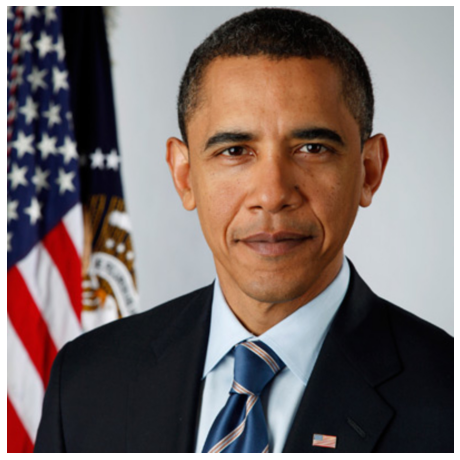

In [74]:
img = cv2.imread('./test_photos/barack.jpg')
plt.figure(figsize=(8,12))
plt.imshow(to_rgb(img))
plt.axis('off');

(-0.5, 1199.5, 1199.5, -0.5)

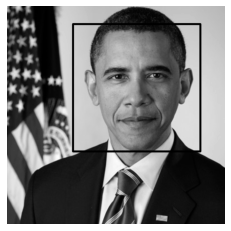

In [75]:
faces, gray = detect_faces(img, draw_rects=True, extension=.1)
plt.imshow(gray, cmap='gray')
plt.axis('off')

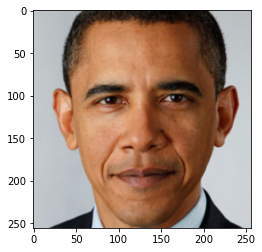

array([-3.2782333e+00, -3.2314980e+00, -1.8581141e+00, -7.2958015e-02,
        1.8673255e+00, -1.5435610e+00,  2.6321621e+00,  4.6105325e-01,
        1.3083487e+00,  3.3491573e+00,  2.9609056e+00, -3.6721709e+00,
       -1.3829248e+00, -9.4341373e-01, -5.4352510e-01,  2.8973809e-02,
        3.1056554e+00, -4.4172847e-01, -4.7656894e-01,  7.9837430e-01,
        1.4001373e+00, -4.8009419e-01, -2.4459646e+00, -4.3042231e-01,
        9.1204137e-01, -2.0357563e+00,  9.4913894e-01, -3.6284885e-01,
        1.1187574e+00, -3.4391129e+00, -8.4512019e-01,  1.9518265e+00,
       -2.0206177e+00,  5.6816995e-01,  5.8080530e-01,  6.4288926e-01,
       -2.2810473e+00,  1.9046064e-01,  5.6999600e-01,  1.5930518e+00,
       -1.3636338e+00,  1.3731956e-01, -2.3108568e-02, -3.1812496e+00,
       -2.0283549e+00, -1.6184011e+00,  7.8908771e-01,  1.4239593e+00,
       -2.5963306e-02,  4.5240846e-01,  2.8690937e+00, -1.7056878e+00,
       -1.0135571e+00, -1.7807555e+00, -9.0069284e+00,  3.6416668e-01,
      

In [76]:
img = faces[0]
plt.imshow(img)
plt.show()
encode_vals(img)

Face found in your image! Evaluating image now...
Done evaluating.
The closest roast to you is  bqil4m


['You look like you put your face right up on the microwave when you heat up curry']

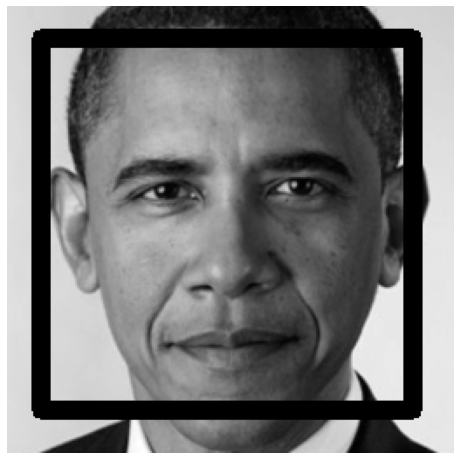

In [78]:
roast, gray = give_corresponding_roast(img, return_gray=True)
plt.figure(figsize=(8,12))
plt.axis('off')
plt.imshow(gray, cmap='gray')
roast

In [36]:
from gtts import gTTS
import os
import time

In [42]:
def read_roast(roast):
    myobj = gTTS(text=roast, lang='en', slow=False)
    myobj.save('roast.mp3')
    os.system('roast.mp3')

#read_roast('Hello, how are you today?')

In [81]:
cam = cv2.VideoCapture(0)

cv2.namedWindow("RoastBot")

img_counter = 0
with open('id_log.txt', 'w') as log_file:
    while True:
        ret, frame = cam.read()
        if not ret:
            print("failed to grab frame")
            break
        cv2.imshow("RoastBot", cv2.flip(frame,1))

        k = cv2.waitKey(1)
        if k%256 == 27:
            # ESC pressed
            break
        elif k%256 == 32:
            # SPACE pressed
            print("Image taken!")
            roast, _id = give_corresponding_roast(frame, return_gray=False, return_id=True)
            if roast is not None:
                print('Thinking...')
                print('ID:',_id)
                log_file.write(_id+'\n')
                read_roast(roast[0])
                print(roast[0])
                cv2.waitKey(-1)
                img = cv2.imread('./faces/{}.png'.format(_id))
                if img is not None:
                    cv2.imshow('Lookalike', cv2.resize(img,(512,512)))
                    cv2.waitKey(2)
                img_counter+=1

cam.release()

cv2.destroyAllWindows()

Image taken!
Face found in your image! Evaluating image now...
Done evaluating.
The closest roast to you is  bo9m0l
Thinking...
ID: bo9m0l
How in the fuck do you look like a Jew AND a nazi?
Image taken!
No face found in your photo! Try another (perhaps the lighting was poor).
Image taken!
No face found in your photo! Try another (perhaps the lighting was poor).
Image taken!
No face found in your photo! Try another (perhaps the lighting was poor).
Image taken!
No face found in your photo! Try another (perhaps the lighting was poor).
Image taken!
No face found in your photo! Try another (perhaps the lighting was poor).


In [82]:
vae.save('VAE')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: VAE\assets
